# Block 8: JAX

Wouldn't it be nice if we didn't have to do the derivative calculations manually? JAX is very similar to numpy, but it has a number of extra important capabilities, the most important of which is auto differentiation of arbitrary computations.

I had a difficult choice at this juncture: whether to introduce you to the more common `pytorch` library, or whether to use the less known `jax`. The first is widely used and somewhat similar to numpy, but introduces a number of new concepts. `jax` is actually faster, and I feel that introduces minimal changes which will hopefully be easier to appreciate within the short time span of this course.

## Objectives

- Learn auto differentiation in JAX
- Learn randomness in JAX
- Modify our linear model to use JAX and auto differentiation
- Quickly test the modified model
- Modify the linear model to become non-linear
- Quickly test the non-linear model

In [1]:
import numpy as np 
import pandas as pd 
from typing import List
import jax.numpy as jnp 
import jax
import matplotlib.pyplot as plt

## Autodiff

In [2]:
# simple gradient
grad_fn = jax.grad(jax.numpy.sin)
grad_fn(0.)
grad_fn = jax.grad(jax.numpy.cos)
grad_fn(0.)

# gradient of a function that takes a parameter
def some_fn(w):
    return w * 2

grad_fn = jax.grad(some_fn)
grad_fn(4.)

# gradient of a function that takes a parameter + an input
def some_fn(w, x):
    return w*x

grad_fn = jax.grad(some_fn)
grad_fn(4., 10)

# gradient of a function that takes multiple parameters
def some_fn(p, x):
    return p['b0'] + p['b1'] * x 

grad_fn = jax.grad(some_fn)
grad_fn({ "b0" : 1., "b1" : 3.5 }, 10.) # neat! will return derivative with respect to b0 and with respect to b1


{'b0': Array(1., dtype=float32, weak_type=True),
 'b1': Array(10., dtype=float32, weak_type=True)}

## Randomness

JAX is explicit about random number generation. There is no magical "global" random number generator seed. Instead, any function that involves any kind of randomness, but receive a "key" that controls how the random numbers are generated.

In [3]:
key = jax.random.key(42)
print(jax.random.normal(key, 3)) # generate 3 standard normal values

print(jax.random.normal(key, 3)) # generate 3 standard normal values, because we are passing the same key, we get the same valeus

key, _ = jax.random.split(key, 2) # split into two new "child" keys ... we just use the first one
print(jax.random.normal(key, 3)) # generate 3 standard normal values, now the key is different so we get a diff value

# this doesn't work, it will keep generating same value
for i in range(10):
    val = jax.random.normal(key, 3)
    print(val)

print()
# a bit better but not ideal ...
key = jax.random.key(42)
for i in range(10):
    key, _ = jax.random.split(key)
    val = jax.random.normal(key, 3)
    print(val)

print()

# good solution
key = jax.random.key(42)
for i in range(10):
    loop_key = jax.random.fold_in(key, i)
    val = jax.random.normal(loop_key, 3)
    print(val)

[-0.02830462  0.46713185  0.29570296]
[-0.02830462  0.46713185  0.29570296]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.07592554 -0.48634264  1.2903206 ]

[ 0.07592554 -0.48634264  1.2903206 ]
[-0.7197971  1.5521808 -0.8557356]
[ 1.5832745   0.06891013 -0.23817426]
[ 0.16889559 -1.978758   -1.169645  ]
[ 0.32114476  0.21683139 -0.9483882 ]
[-0.69533247  0.40693274  0.3515198 ]
[-1.0713949   0.20744139  1.0686921 ]
[-1.490867    0.15006733 -0.24445076]
[ 0.64465773 -1.0203602  -1.672845  ]
[1.1716218  0.42618108 0.23057559]

[ 0.07592554 -0.48634264  1.2903206 ]
[ 0.60576403  0.7990441  -0.908927  ]
[ 0.4323065  0.5872638 -1.1416743]
[-0.2818947 -1.3674

# LinearModel with AutoDiff

I copied the functions from `linear_model_numpy.py` and made few changes to adapt the code to jax

In [ ]:
def prepare_inputs(input_df):
    """
        Prepares the input features that will be fed into the model.

        Inputs:
            input_df: the input dataframe into the function. Should consist ONLY of input features.
        Outputs:
            Z: the input feature matrix of size NxK, where K is the number of features
    """
    # Let's identify categorical columns in a dataframe
    categorical_cols = input_df.select_dtypes(include='object').columns
    
    # Let's identify the numeric columns in the dataframe
    numeric_cols = input_df.select_dtypes(include='number').columns

    # We want to construct the input features into the model
    # We will use a numpy array that contains both numeric and categorically encoded values
    X = input_df[numeric_cols].to_numpy() # (NxK)
    
    # Now we need to z-score the numeric features so that they can lead to efficient learning
    col_means = np.mean(X, axis=0) # K
    col_stds = np.std(X, axis=0, ddof=1) # K
    
    # Z-score
    # (NxK - 
    #  1xK) 
    #  / 
    #  (1xK)
    Z = (X - col_means[None, :]) / col_stds[None, :]
    
    # Now we want to code the categorical columns using one-hot encoding
    for col in categorical_cols:
        # NxC (C is the number of unique values in the column)
        # So for origin this will be Nx3 
        dummies = pd.get_dummies( input_df[col] ).to_numpy() 
        
        # concatenate dummies matrix onto Z
        #print(Z.shape)
        #print(dummies.shape)
        Z = np.hstack((Z, dummies)) 
    
    # finally we want to add a column of ones at the start of Z
    ones_col = np.ones((Z.shape[0], 1)) # Nx1
    
    Z = np.hstack((ones_col, Z))

    # go to JAX domain
    return jnp.array(Z) # <-- JAX

@jax.jit # <-- this optimizes the function to run faster, but requires certain constraints. Mainly, no pandas!
def forward_fn(Beta, Z):
    """
        Linear regression forward function.
        Implements the equation y(x) = b0 + b1 * x1 + b2 * x2 + ...
        
        Inputs:
            Beta: the coefficients of the model (size K)
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
        Output:
            yhat: the model's predictions (size N)
    """
    return Z @ Beta

def predict(Beta, input_df):
    """
        Convienience function that prepares inputs and runs the forward function.

        Inputs:
            Beta: the coefficients of the model (size K)
            input_df: input data frame (input features only, no output column).
        Output:
            yhat: the model's predictions (size N)
    """
    Z = prepare_inputs(input_df)
    return forward_fn(Beta, Z)

@jax.jit # <-- optimize
def loss_fn(Beta, Z, y):
    """
        Computes the mean squared error loss function for the model.

        Inputs:
            Beta: the coefficients of the model (size K)
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
            y: actual observations (size N)
        Output:
            mse: mean squared error
    """
    yhat = forward_fn(Beta, Z)
    mse = jnp.mean(jnp.square(yhat - y)) # <-- JAX
    return mse 

def optimize(rng, input_df, y, learning_rate, epochs):
    """
        Input parameters:
            rng: JAX random key to be used for initializing solution
            input_df: dataframe containing input columns
            y: a vector of outputs that we wish to predict
            learning_rate: how quickly we want gradient descent learning
            epochs: the number of steps of gradient descent
        Output:
            Beta: fitted model parameters
    """

    # move y into jax's domain
    y = jnp.array(y) # <-- JAX
    
    # Create a function that computes the gradient of the loss_fn with respect to the first argument (Beta)
    grad_fn = jax.grad(loss_fn) # <-- JAX

    # Prepare our inputs into the linear regression
    Z = prepare_inputs(input_df) # NxK

    # Randomly initialize our solution
    Beta = jax.random.normal(key = rng, shape=Z.shape[1]) # <-- JAX
    
    # Run gradient descent loop
    for i in range(epochs):
        # compute gradient
        # this is very powerful ... JAX takes care of derivative computation
        # so loss_fn (and forward_fn) could be as complex as you like
        # as long as they are reasonably continous
        Beta_grad = grad_fn(Beta, Z, y) # <-- JAX
        
        # Update the parameters
        Beta = Beta - learning_rate * Beta_grad

    # Beta is the fitted parameter values
    return Beta


In [11]:
# load dataset
df = pd.read_json('../data/cars.json')

# Filter dataframe
required_cols = ['Miles_per_Gallon', 'Cylinders', 'Displacement', 'Horsepower', 'Weight_in_lbs', 'Acceleration', 'Origin']

# only include rows where ALL columns are not nan
ix_included = np.sum(pd.isna(df[required_cols]), axis=1) == 0

# exclude examples with no horsepower or mpg
print("Before: ", df.shape)
df = df[ix_included]
print("After: ", df.shape)
df = df[required_cols]

Before:  (406, 9)
After:  (392, 9)


In [9]:
# Let's test the new class 
rng = jax.random.key(1234)

input_features = ['Displacement', 'Origin', 'Cylinders', 'Horsepower']
input_df = df[input_features]
y = df.Miles_per_Gallon.to_numpy()

Beta = optimize(rng, input_df, y, learning_rate=0.1, epochs=500)
Beta

Z = prepare_inputs(input_df)
mse = loss_fn(Beta, Z, y)
print(mse)

# try with different rng seed

19.055416


## Non-Linear Model

Let's make a slight change to the model, so that it is non-linear:

$f(\mathbf{x}_{i})=\text{exp}(\frac{1}{K}(b_{0}+b_{1}x_{i1}+...+b_{k}x_{iK}))$

In [12]:
@jax.jit
def forward_fn(Beta, Z):
    """
        Nonlinear model forward function.
        Implements the equation y(x) = exp(b0 + b1 * x1 + b2 * x2 + ...)
        
        Inputs:
            Beta: the coefficients of the model (size K)
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
        Output:
            yhat: the model's predictions (size N)
    """
    u = Z @ Beta # NxK @ K = N
    u = u / Z.shape[1]
    return jnp.exp(u)

# At this point, forward_fn overrides the previous definition
# so all the functions that use forward_fn will be using the latest one instead
# even if you try to run the cell above, it will use this function.

In [13]:
# Let's test the new class 
rng = jax.random.key(143143)

input_features = ['Displacement', 'Origin', 'Cylinders', 'Horsepower']
input_df = df[input_features]
y = df.Miles_per_Gallon.to_numpy()

Beta = optimize(rng, input_df, y, learning_rate=0.01, epochs=500)

Z = prepare_inputs(input_df)
mse = loss_fn(Beta, Z, y)
print(mse)

# try with different rng seed

16.242918


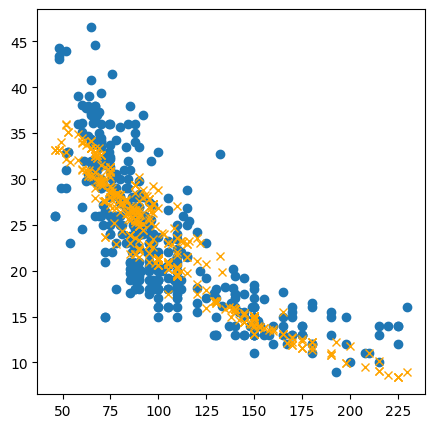

In [15]:
yhat = predict(Beta, input_df)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(input_df.Horsepower, df.Miles_per_Gallon, marker='o', linestyle='')
ax.plot(input_df.Horsepower, yhat, marker='x', linestyle='', color='orange')